In [146]:
using Accessors
using CSV
using DataFrames
using Distributions
using Interpolations
using Parameters
using Plots
using ProtoStructs
using ProgressMeter
using Random
using StatsBase
using StatsPlots

include("util.jl")
include("model.jl")

fetch_first_date (generic function with 1 method)

## Virus shedding

In [147]:
p = BaseParams(N0=10_000)
dump(p)

BaseParams{NamedTuple{(:R0, :γ1, :γ2, :γ3, :p_AFP, :β, :days, :N0, :I0_init, :λ0), Tuple{Float64, Float64, Float64, Float64, Float64, Float64, Int64, Int64, Int64, Float64}}}
  properties: NamedTuple{(:R0, :γ1, :γ2, :γ3, :p_AFP, :β, :days, :N0, :I0_init, :λ0), Tuple{Float64, Float64, Float64, Float64, Float64, Float64, Int64, Int64, Int64, Float64}}
    R0: Float64 10.0
    γ1: Float64 0.25
    γ2: Float64 0.041666666666666664
    γ3: Float64 0.2
    p_AFP: Float64 0.005
    β: Float64 0.41666666666666663
    days: Int64 365
    N0: Int64 10000
    I0_init: Int64 1
    λ0: Float64 76.0


In [148]:
virus = CSV.read("../data/Andrew2023.csv", DataFrame)
days = virus[:, :day] .|> Float64
vals = virus[:, :log_conc_shedding]

gs = relative_virus_shedding(days, vals)
#ys = ys/sum(ys
plot(days, vals, marker=:circle, label="Observed values",
     ylabel="Shedding conc., log(CID_50)",
     xticks=[i for i in 0:7:100],
)
xs = gs |> keys |> collect
ys = gs |> values |> collect
inds = sortperm(xs)


101-element Vector{Int64}:
  63
  84
  50
  92
  14
   1
   8
  40
  81
  66
  51
  30
  23
   ⋮
  90
  13
  19
  27
  49
  71
  42
  94
 101
  34
  89
  57

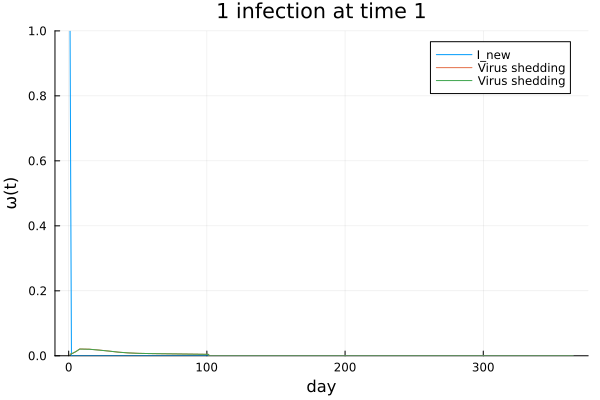

In [149]:
# TODO: calculate hazard value analytically.
#λ0 = 76
λ0 = 1
ts = 1:p.days
I_new = vcat([1] , [0 for _ in 2:p.days])
λ = [hazard_function(I_new, gs, t; λ0=λ0)  for t in ts]
ω = 1 .- exp.(-λ)
pl = plot(
    title="1 infection at time 1", 
    ylim=(0,1.0), 
    #yticks=((1.0, 0.8)),
    yticks=([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5]),
    fmt=:png,
)
plot!(pl, ts, I_new, label="I_new", xlabel="day", ylabel="ω(t)")
plot!(pl, ts, λ, label="Virus shedding")
plot!(pl, ts, ω, label="Virus shedding")
display(pl)

## Simulations 

In [150]:
include("util.jl")
include("model.jl")

fetch_first_date (generic function with 1 method)

In [151]:
p = BaseParams()
dump(p)

BaseParams{NamedTuple{(:R0, :γ1, :γ2, :γ3, :p_AFP, :β, :days, :N0, :I0_init, :λ0), Tuple{Float64, Float64, Float64, Float64, Float64, Float64, Int64, Int64, Int64, Float64}}}
  properties: NamedTuple{(:R0, :γ1, :γ2, :γ3, :p_AFP, :β, :days, :N0, :I0_init, :λ0), Tuple{Float64, Float64, Float64, Float64, Float64, Float64, Int64, Int64, Int64, Float64}}
    R0: Float64 10.0
    γ1: Float64 0.25
    γ2: Float64 0.041666666666666664
    γ3: Float64 0.2
    p_AFP: Float64 0.005
    β: Float64 0.41666666666666663
    days: Int64 365
    N0: Int64 10000
    I0_init: Int64 1
    λ0: Float64 76.0


  0.092925 seconds (152.43 k allocations: 8.050 MiB, 99.79% compilation time)


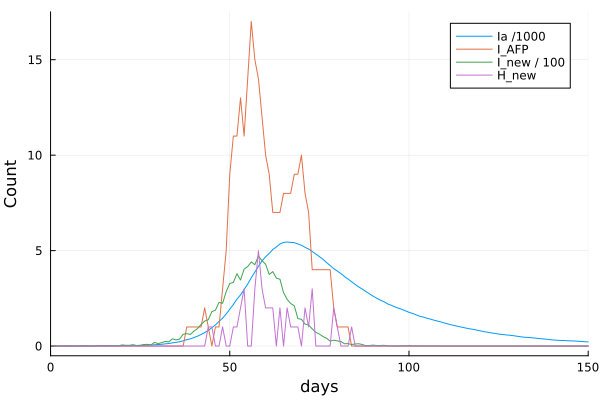

In [152]:
Random.seed!(10)
@time res = run_sim(p)
d_afp1, d_wt1 = fetch_first_date(p, res)

pl = plot(xlim=[0,150], xlabel=:days, ylabel="Count", fmt=:png)
plot!(pl, 1:p.days, res.Ia/1000, label="Ia /1000")
plot!(pl, 1:p.days, res.I_AFP, label="I_AFP")
plot!(pl, 1:p.days, res.I_new/100, label="I_new / 100")
plot!(pl, 1:p.days, res.H_new, label="H_new")
#plot!(pl, 1:p.days, res.R/1000, label="R /1000")

In [153]:
n_sim = 1000
ds_afp1 = []
ds_wt1 = []
for i in 1:n_sim
    for _ in 1:1e4
        res = run_sim(p)
        n = res.I_new |> sum
        if n > 10; break; end
    end
    d_afp1, d_wt1 = fetch_first_date(p, res)
    ds_afp1 = vcat(ds_afp1, d_afp1)
    ds_wt1 = vcat(ds_wt1, d_wt1)
end

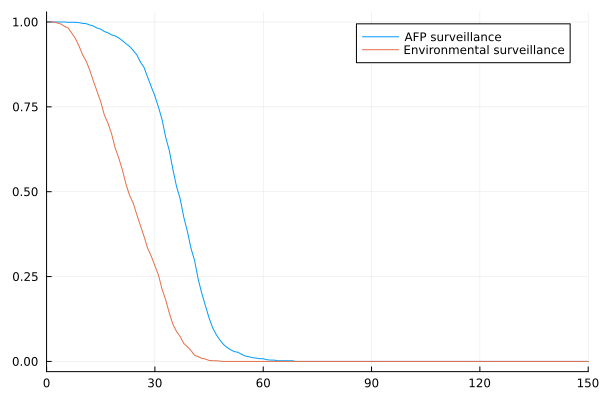

In [154]:
surv_afp1 = [0 for _ in 1:p.days]
surv_wt1 = [0 for _ in 1:p.days]
for (da, dw) in zip(ds_afp1, ds_wt1)
    surv_afp1[da] += 1
    surv_wt1[dw] += 1
end
surv_afp1 = 1 .- cumsum(surv_afp1)/n_sim
surv_wt1 = 1 .- cumsum(surv_wt1)/n_sim
pl = plot(xticks=0:30:150, fmt=:png, 
    xlim=[0,150], 
)
plot!(pl, 1:p.days, surv_afp1, label="AFP surveillance")
plot!(pl, 1:p.days, surv_wt1, label="Environmental surveillance")

Summary Stats:
Length:         1000
Missing Count:  0
Mean:           12.978000
Minimum:        -25.000000
1st Quartile:   4.000000
Median:         13.000000
3rd Quartile:   22.000000
Maximum:        53.000000
Type:           Int64
nothing


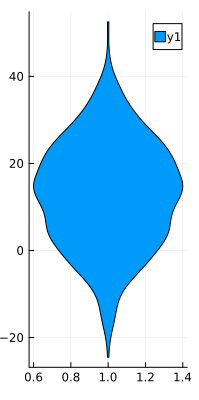

In [158]:
lead_wt1 = ds_afp1 .- ds_wt1 
describe(lead_wt1) |> println
pl = plot(size=(200,400), fmt=:png)
df = DataFrame(Dict(:x=>lead_wt1))
@df df violin!(pl, :x)

In [166]:
n_delay = (lead_wt1 .< 0) |> sum 
n_delay/n_sim*100

14.499999999999998

## Interpolate.jl 

In [ ]:
A_x1 = 1:.1:10
A_x2 = 1:.5:20
f(x1, x2) = log(x1+x2)
A = [f(x1,x2) for x1 in A_x1, x2 in A_x2]
itp = interpolate(A, BSpline(Cubic(Line(OnGrid()))))
sitp = Interpolations.scale(itp, A_x1, A_x2)
sitp(5., 10.) # exactly log(5 + 10)
sitp(5.6, 7.1) # approximately log(5.6 + 7.1)

2.541602006923902

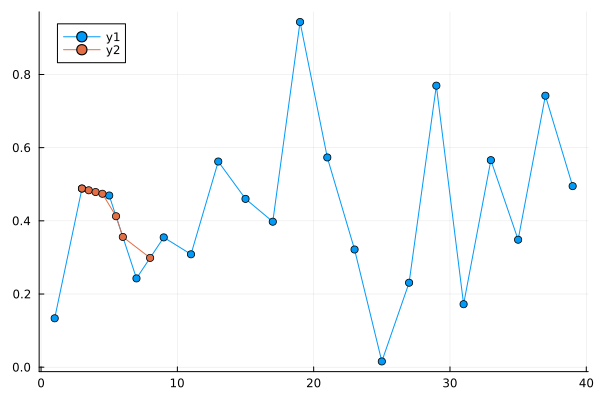

In [ ]:
A = rand(20)
A_x = 1.0:2.0:40.0
nodes = (A_x,)
itp = interpolate(nodes, A, Gridded(Linear()))
x = [3, 3.5, 4, 4.5, 5.5, 6.0,  8]
plot(nodes, A, marker=:circle)
plot!(x, [itp(xx) for xx in x], marker=:circle)

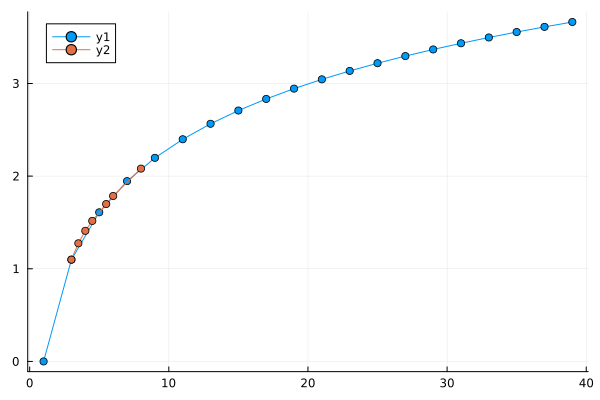

In [ ]:
A_x = 1.:2.:40.
A = [log(x) for x in A_x]
itp = interpolate(A, BSpline(Cubic(Line(OnGrid()))))
sitp = Interpolations.scale(itp, A_x)
sitp(3.) # exactly log(3.)
sitp(3.5) 
plot(A_x, A, marker=:circle)
x = [3, 3.5, 4, 4.5, 5.5, 6.0,  8]
plot!(x, [sitp(xx) for xx in x], marker=:circle)